# Initialization

In [1]:
DATA_DIR = "../Data/VOC2012"

# Data

Data is handled by `Datasets` in the `revolver.data` module.

- `revolver.data.seg` defines the base segmentation dataset interface and masking datasets that load mask-wise instead of image-wise.
- `revolver.data.pascal` has datasets for VOC` semantic and instance segmentation.
- `revolver.data.sparse` has a wrapper for static and dynamic sparse targets.
- `revolver.data.filter` has wrappers for filtering and mapping targets.

The wrappers are compositional so that a given kind of data can be loaded by composing a base dataset with the necessary wrappers. This notebook illustrates common use cases.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from revolver.data.pascal import VOCSemSeg, VOCInstSeg
from revolver.data.seg import MaskSemSeg, MaskInstSeg
from revolver.data.sparse import SparseSeg
from revolver.data.filter import TargetFilter, TargetMapper

Let's make dataset.

In [3]:
voc_sem_seg = VOCSemSeg(root_dir=DATA_DIR)
voc_inst_seg = VOCInstSeg(root_dir=DATA_DIR)

print("Dataset with {} images in split {} and {} classes:\n{}".format(len(voc_sem_seg), voc_sem_seg.split, voc_sem_seg.num_classes, voc_sem_seg.classes))

Dataset with 1464 images in split train and 21 classes:
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


Having done that let's make a helper to inspect the data.

In [4]:
def load_and_show(ds, title, count=1):
    for i in range(count):
        im, target, aux = ds[np.random.randint(0, len(ds))]

        im = Image.fromarray(im, mode='RGB')
        target = Image.fromarray(target, mode='P')
        target.putpalette(ds.palette)  # plot with pretty colors

        fig, axs = plt.subplots(1, 2)

        axs[0].set_title(title + " - " + str(aux), loc="left")
        axs[0].imshow(im)
        axs[0].axis('off')
        axs[1].imshow(target)
        axs[1].axis('off')

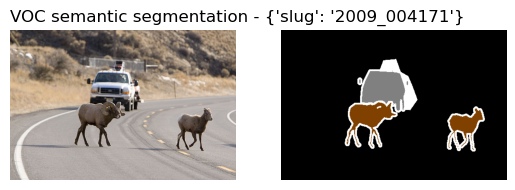

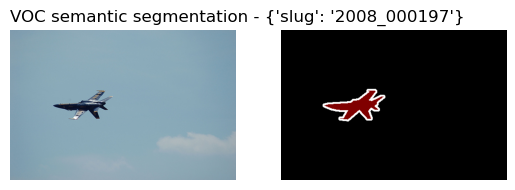

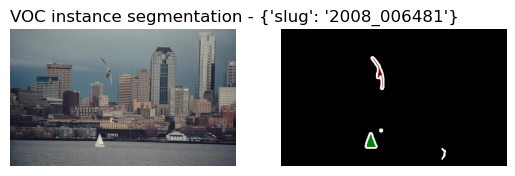

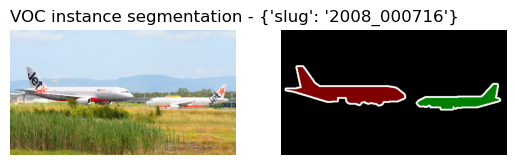

In [5]:
load_and_show(voc_sem_seg, "VOC semantic segmentation", count=2)
load_and_show(voc_inst_seg, "VOC instance segmentation", count=2)

Masking decomposes the dataset over masks instead of images. Indexing mask-wise instead of image-wise makes it possible to sample fairly over all masks whether they are class or instance masks. Were the indexing over images, first sampling an image and then sampling a mask would sample masks inversely proportionally to the number of masks in the image.

These datasets return the **binary** segmentation of a single mask as the target along with class and instance indices in the auxiliary dict.

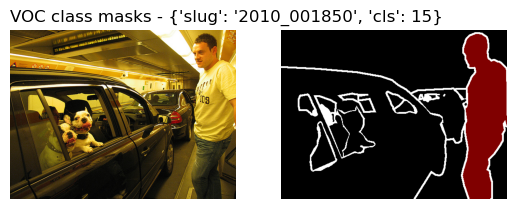

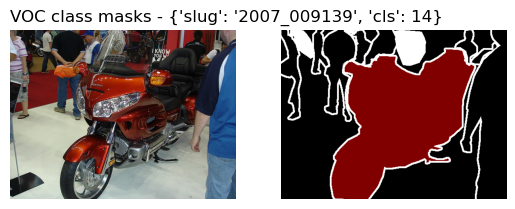

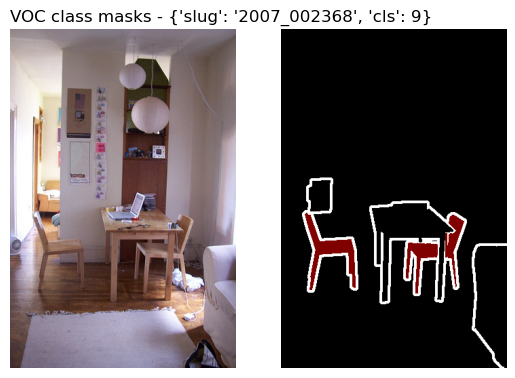

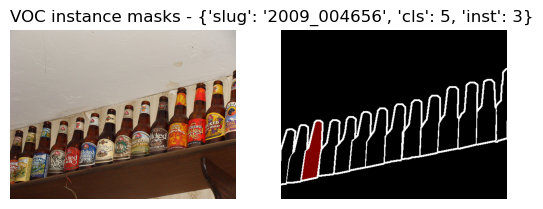

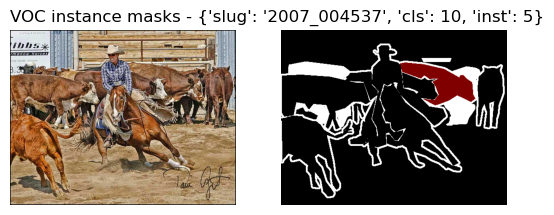

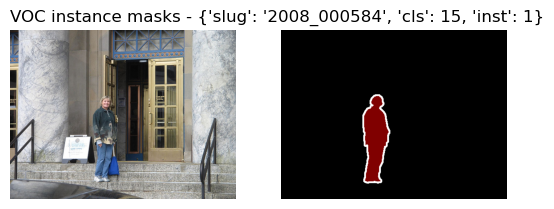

In [6]:
mask_sem_seg = MaskSemSeg(voc_sem_seg)
load_and_show(mask_sem_seg, "VOC class masks", count=3)

# instance masking requires both a semantic seg and an instance seg dataset to preserve class information
mask_inst_seg = MaskInstSeg(voc_sem_seg, voc_inst_seg)
load_and_show(mask_inst_seg, "VOC instance masks", count=3)

Sparsity makes targets that are spatially sparse. The `SparseSeg` wrapper takes a count and limits every target value, whether class or instance, to that many points. The sparsity can be dynamic (the default), and sampled on every load, or static, and sampled once and for all on init to simulate a fixed sparse dataset.

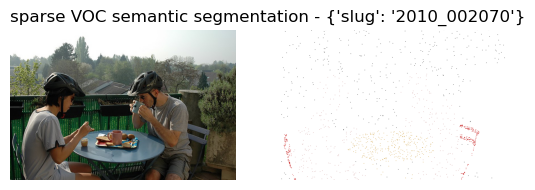

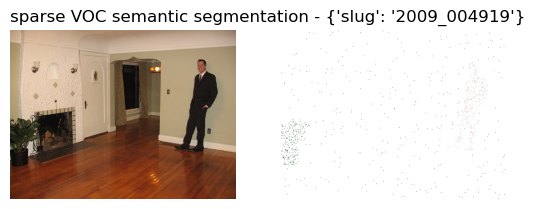

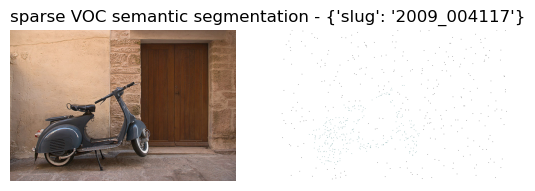

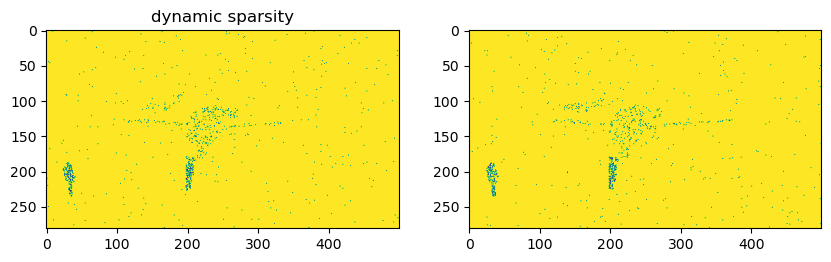

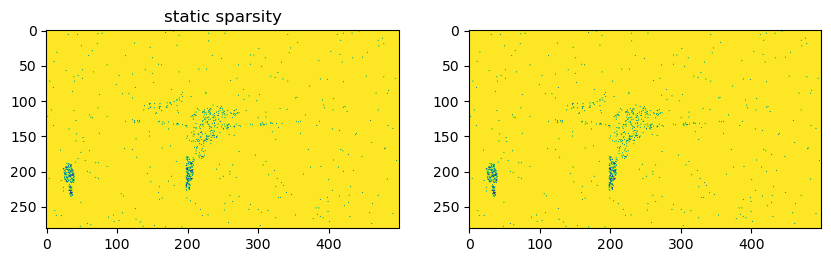

In [7]:
# reduce masks to 100 points per class, resampled on every load
sparse_seg = SparseSeg(voc_sem_seg, count=300)
load_and_show(sparse_seg, "sparse VOC semantic segmentation", count=3)

# dynamic: re-loading does choose new points
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("dynamic sparsity")
im, target, aux = sparse_seg[0]
plt.imshow(target)
plt.subplot(1, 2, 2)
im, target, aux = sparse_seg[0]
plt.imshow(target)

# static: re-loading does not choose new points
static_sparse_seg = SparseSeg(voc_sem_seg, count=300, static=True)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("static sparsity")
im, target, aux = static_sparse_seg[0]
plt.imshow(target)
plt.subplot(1, 2, 2)
im, target, aux = static_sparse_seg[0]
plt.imshow(target)

Filtering and mapping restricts and transforms targets.

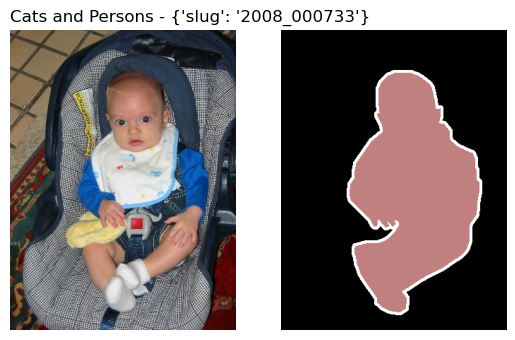

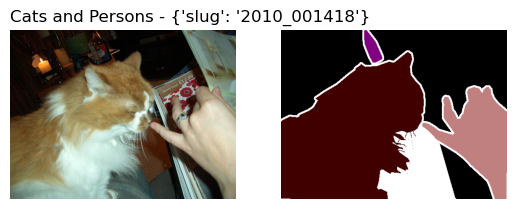

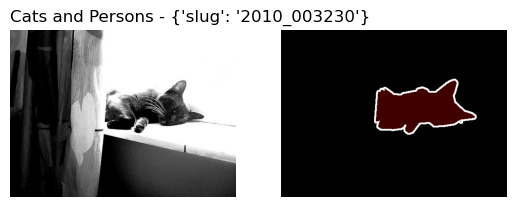

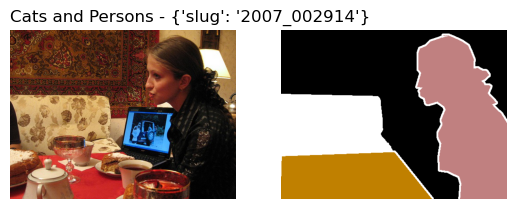

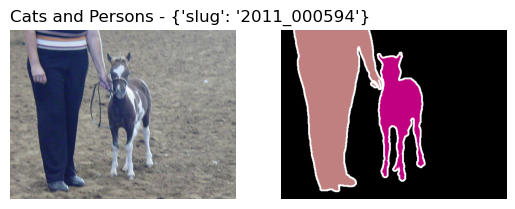

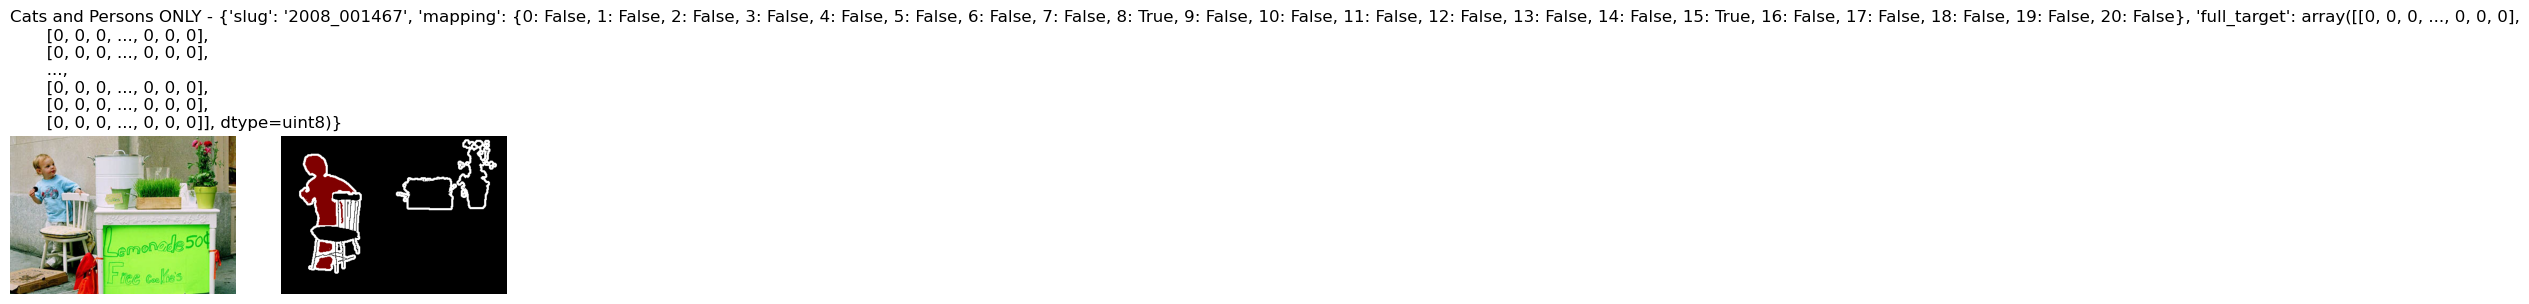

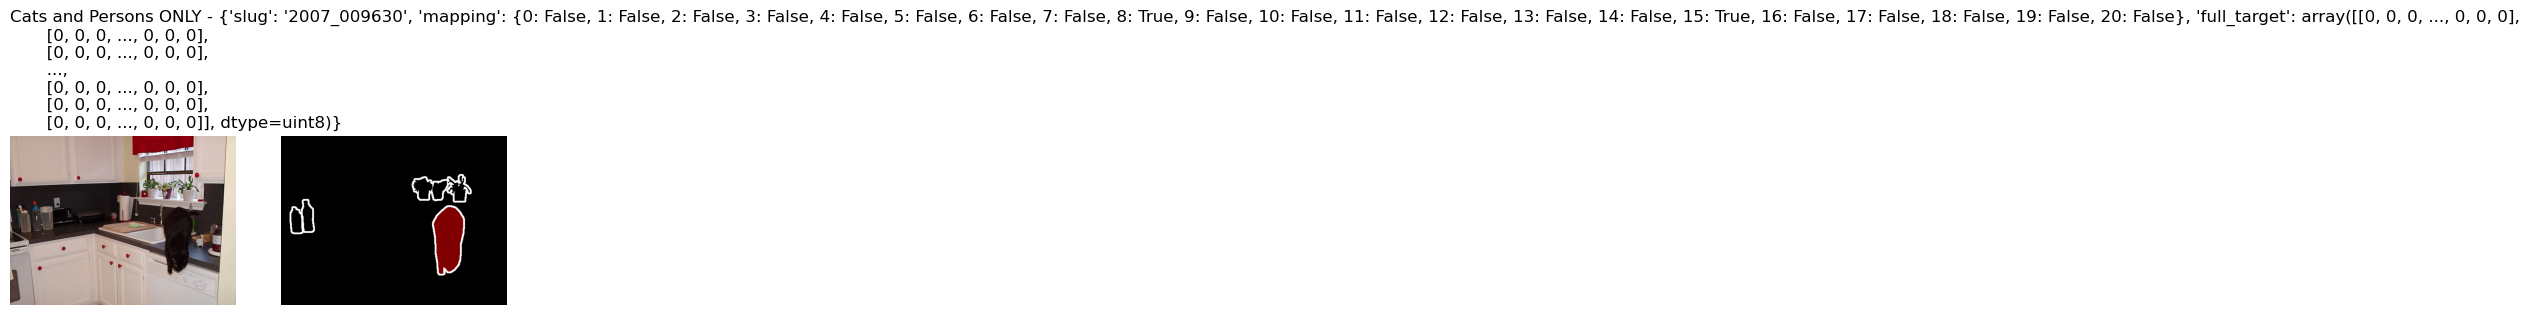

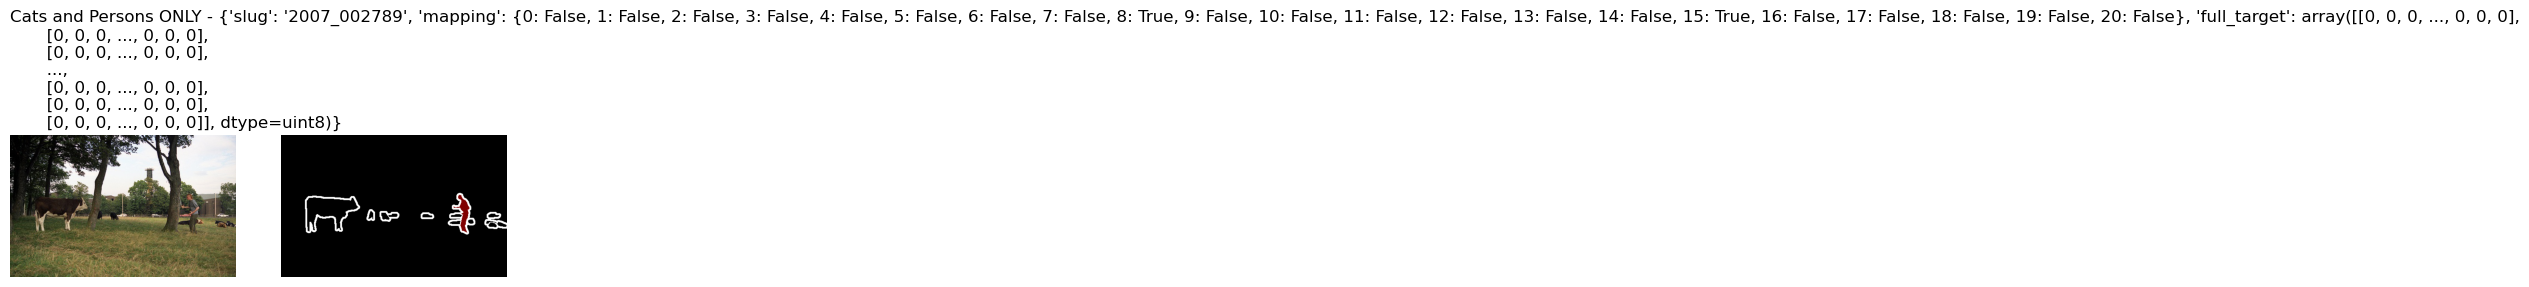

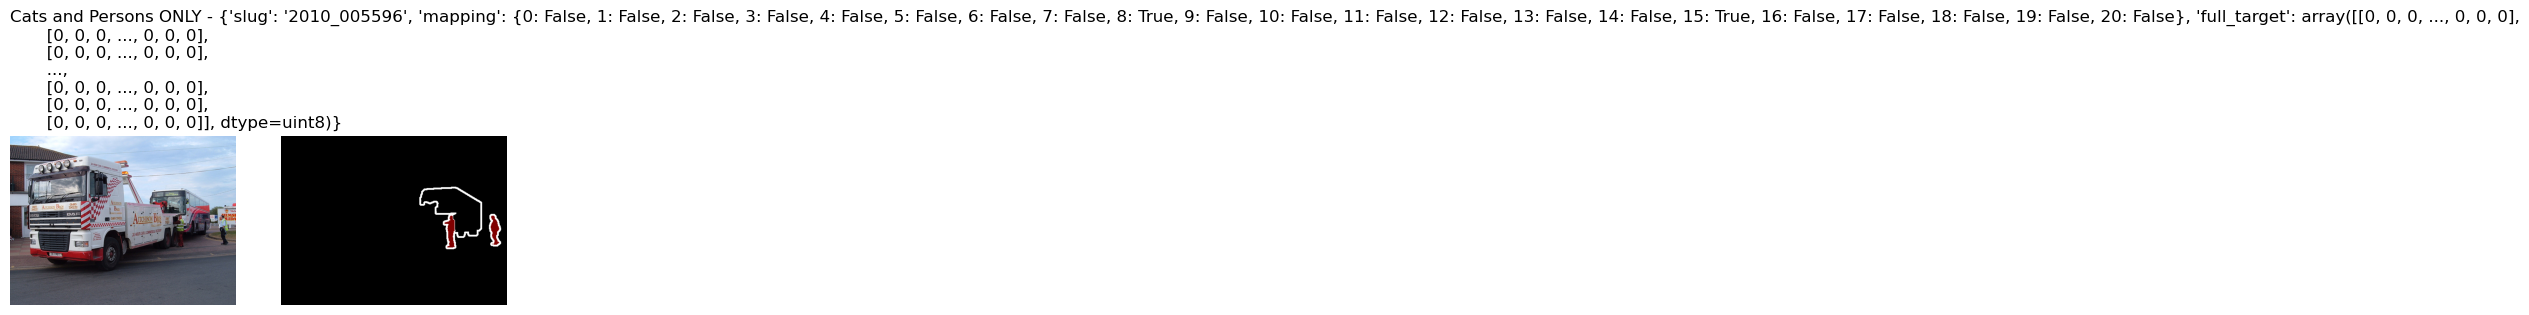

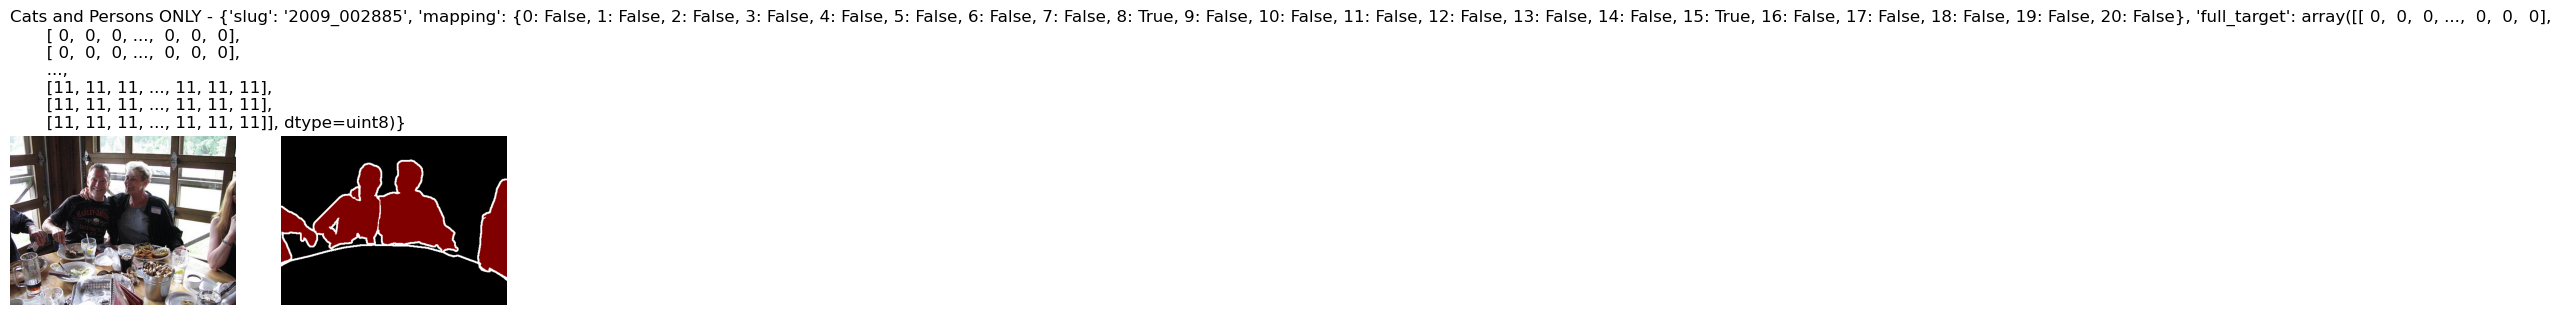

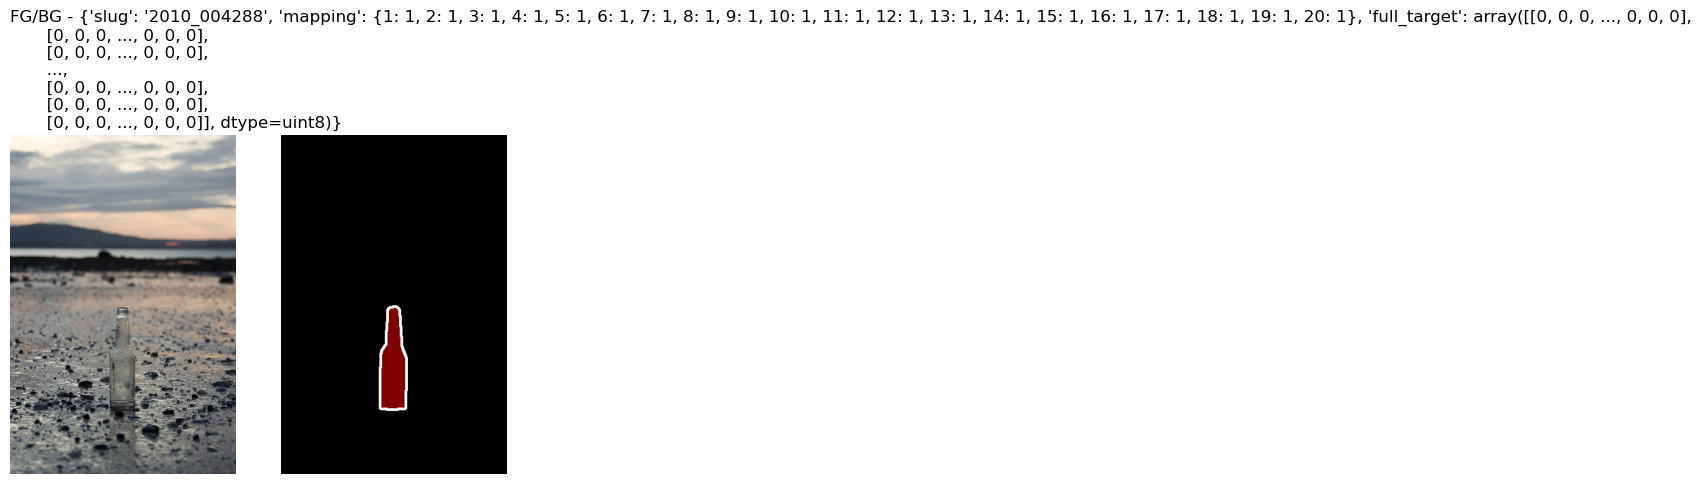

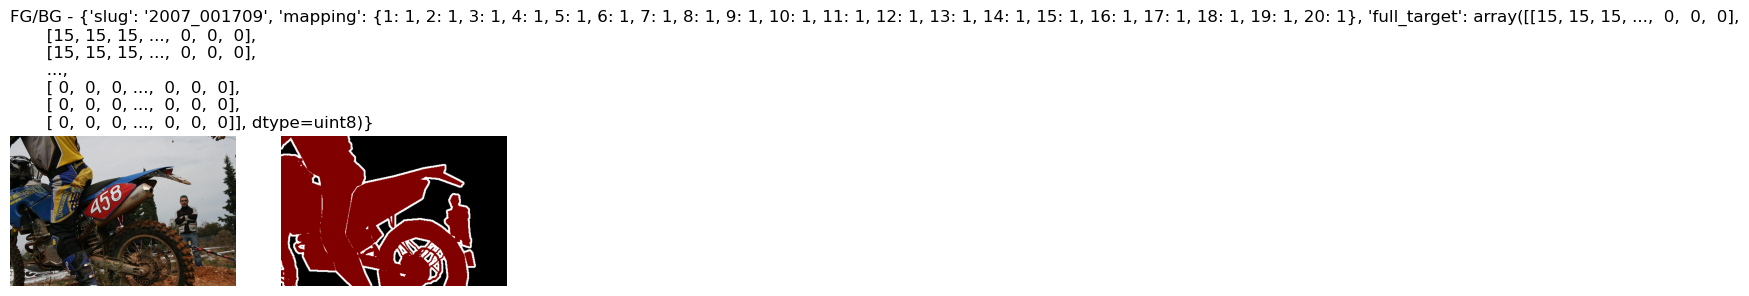

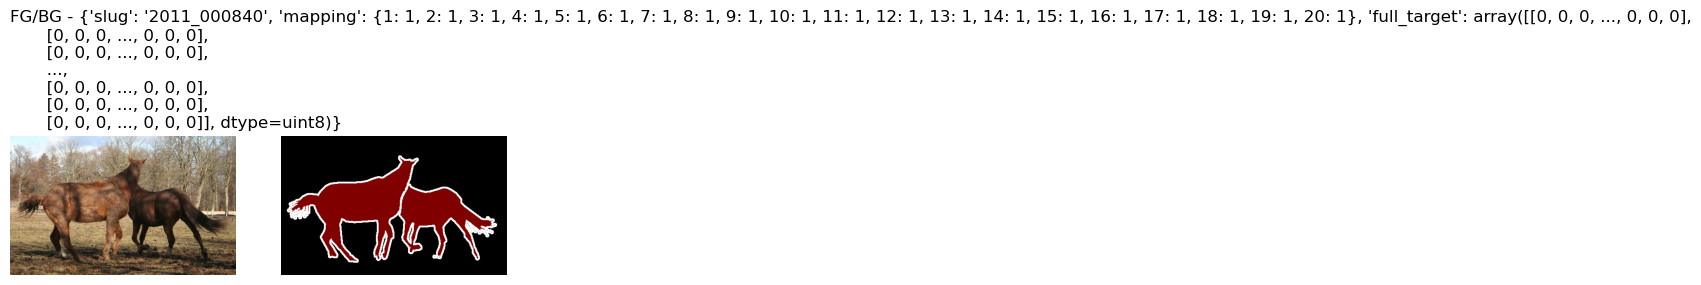

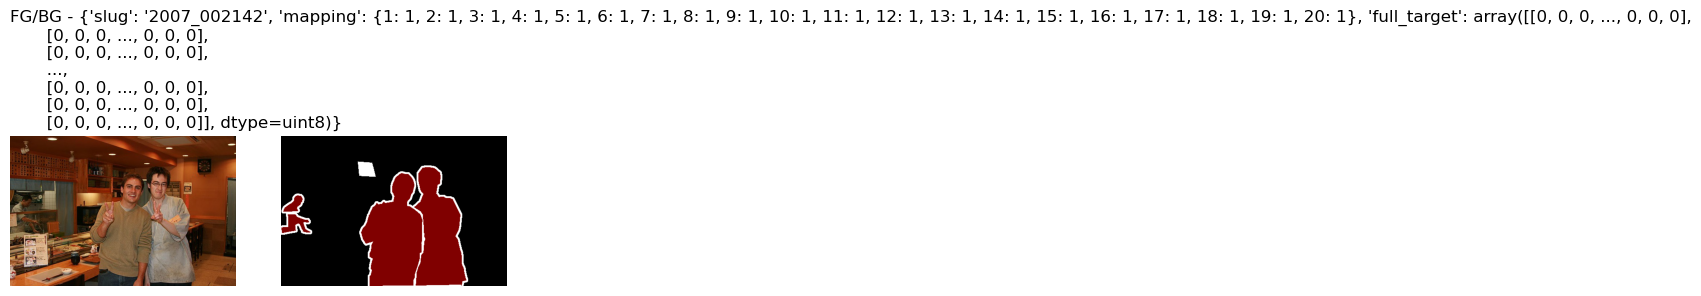

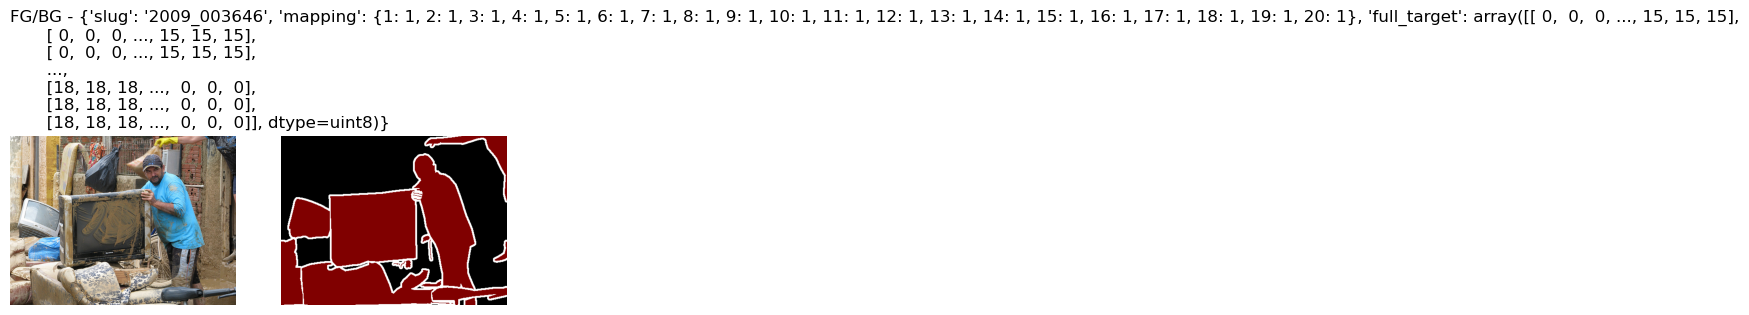

In [8]:
# filter classes to only load images that include the filtered classes
classes_to_filter = (voc_sem_seg.classes.index('cat'), voc_sem_seg.classes.index('person'))
ds_filtered = TargetFilter(voc_sem_seg, classes_to_filter)
load_and_show(ds_filtered, "Cats and Persons", count=5)

# filter classes to only load images that include the filtered classes, and exclude other classes from the target
ds_mapped = TargetMapper(ds_filtered, {k: k in classes_to_filter for k in range(len(voc_sem_seg.classes))})
load_and_show(ds_mapped, "Cats and Persons ONLY", count=5)

# collapse all classes to make foreground/background target
ds_fgbg = TargetMapper(voc_sem_seg, {k: 1 for k in range(1, len(voc_sem_seg.classes))})
load_and_show(ds_fgbg, "FG/BG", count=5)

Now, let's combine the datasets and wrappers to make sparse instance masks of cats.

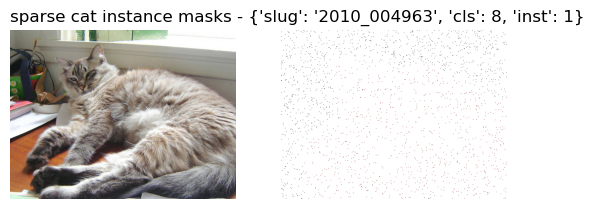

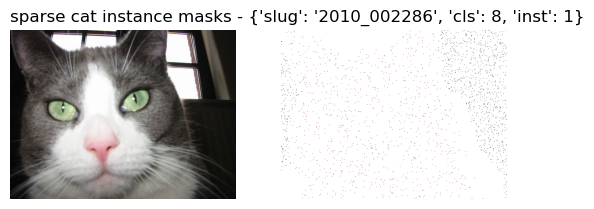

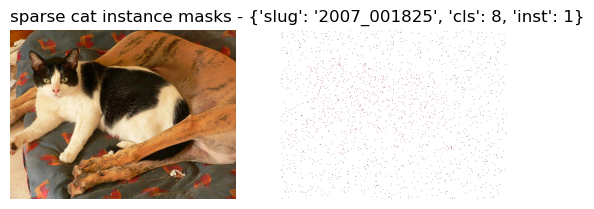

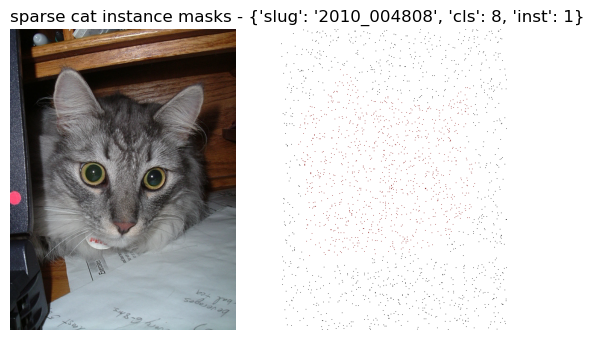

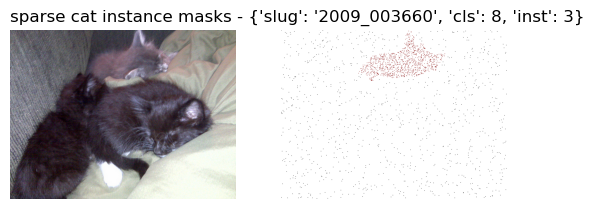

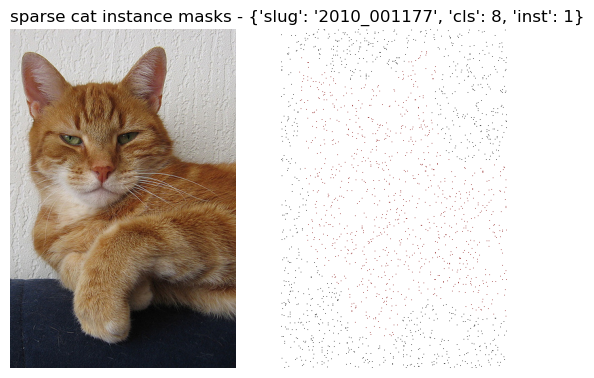

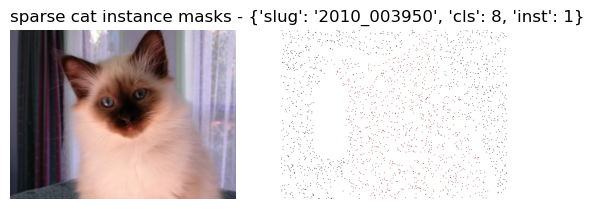

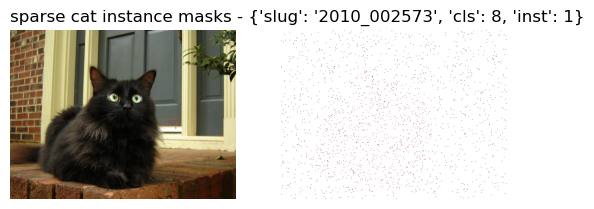

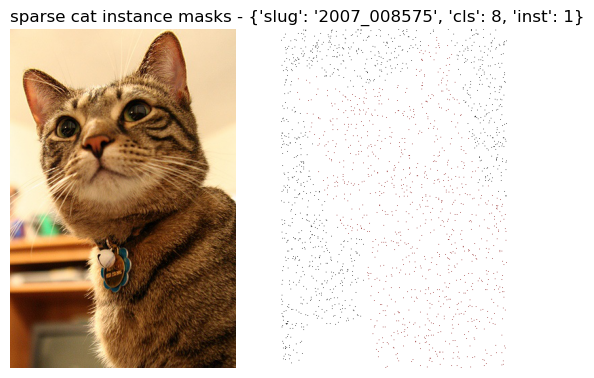

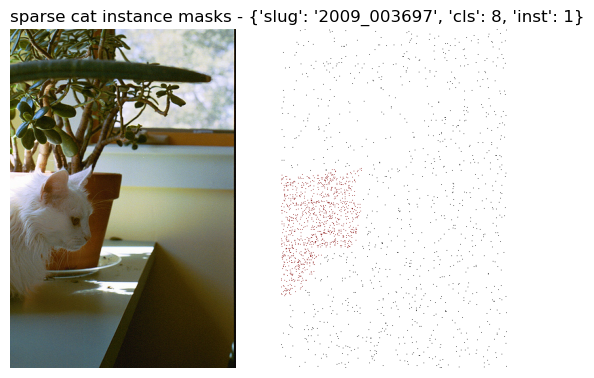

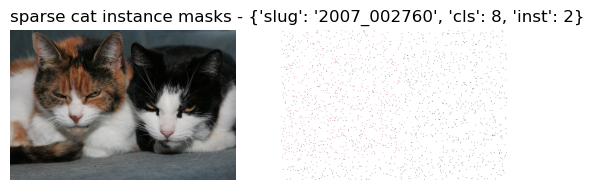

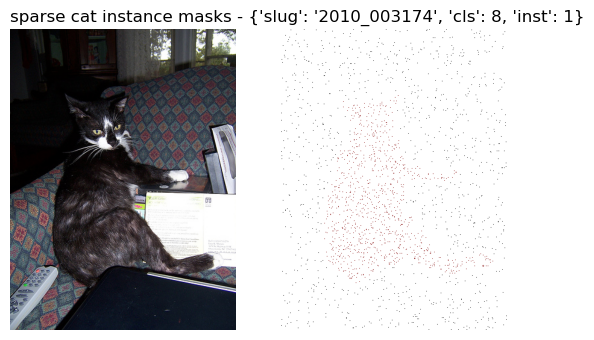

In [9]:
target_filter_cat = TargetFilter(mask_inst_seg, (mask_inst_seg.classes.index('cat'),))
sparse_seg_cat = SparseSeg(target_filter_cat, count=1000)
load_and_show(sparse_seg_cat, "sparse cat instance masks", count=12)

Note that `Datasets`, including compositional datasets that inherit from the `Wrapper` mixin such as the masking datasets, can be cached by pickling/unpickling. This can save a lot of time, as long as care is taken to fully decide the name for the cache file. Try running the cell below and compare it to the timing of the original instantiation above.

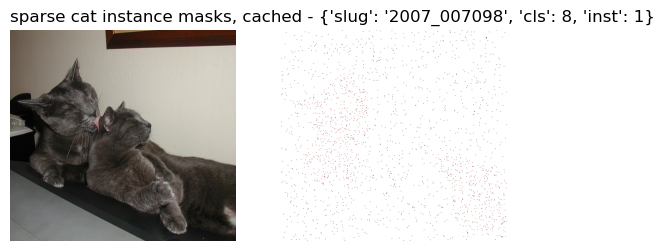

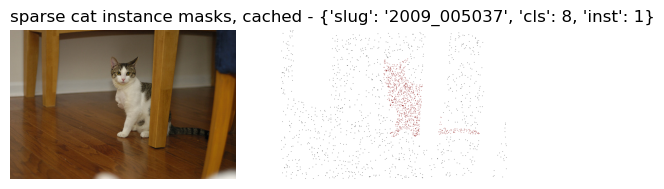

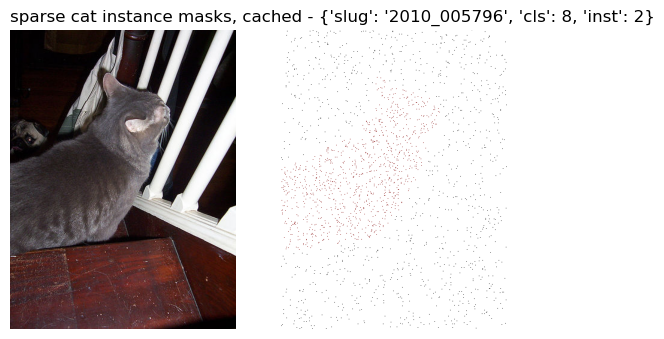

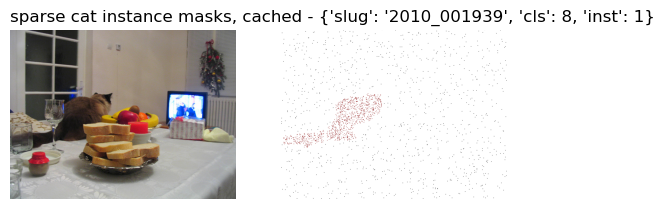

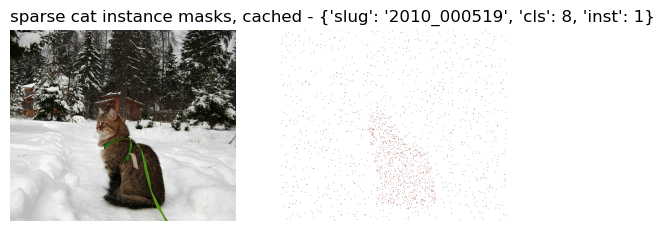

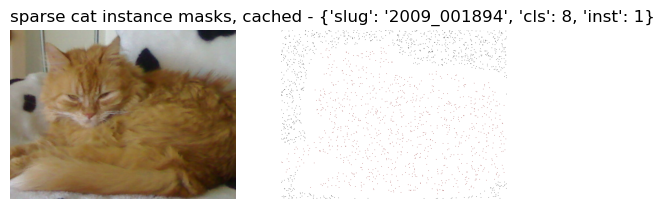

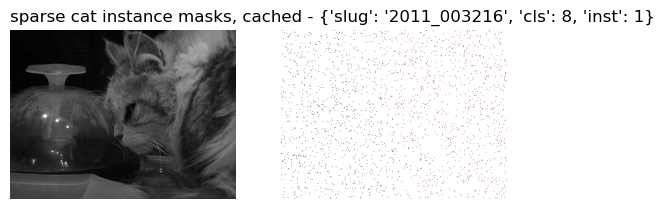

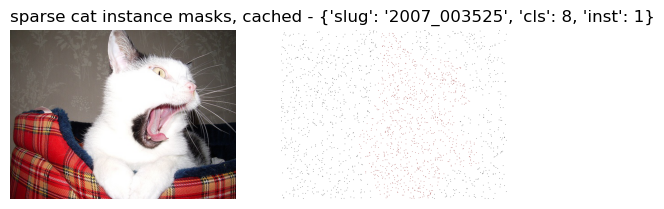

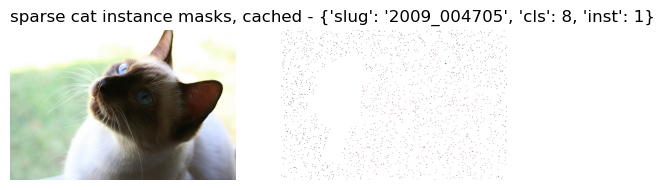

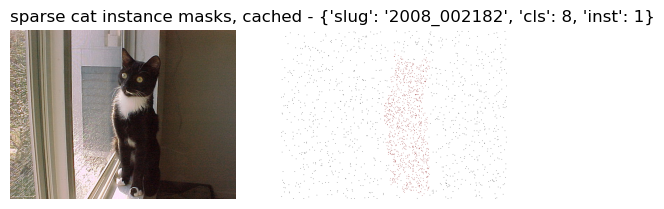

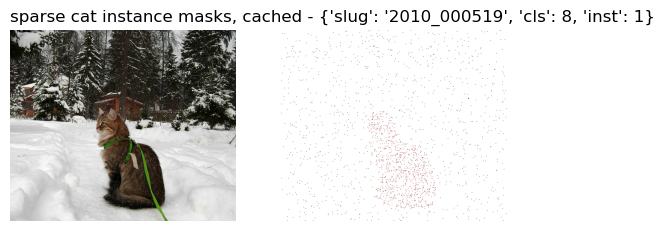

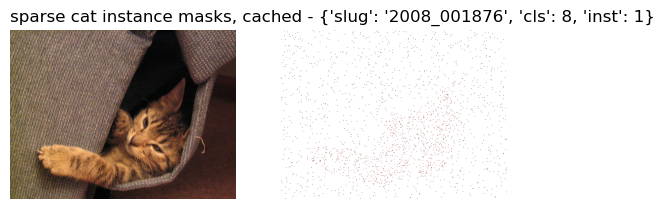

In [10]:
import pickle
import os

cache_path = "./cache/ds-cache.pkl"

pickle.dump(sparse_seg_cat, open(cache_path, 'wb'))
del sparse_seg_cat

sparse_seg_cat_loaded = pickle.load(open(cache_path, 'rb'))
os.remove(cache_path)

load_and_show(sparse_seg_cat_loaded, "sparse cat instance masks, cached", count=12)

# Few-Shot Data

Few-shot datasets return tasks consisting of support (image and annotatations), and query (image and ground truth target).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw

from torchvision.transforms import Compose

from revolver.data.pascal import VOCSemSeg, VOCInstSeg, SBDDSemSeg, SBDDInstSeg
from revolver.data.seg import MaskSemSeg, MaskInstSeg
from revolver.data.filter import TargetFilter
from revolver.data.sparse import SparseSeg
from revolver.data.interactive import InteractiveSeg
from revolver.data.conditional import ConditionalSemSeg

Here are some helpers we'll need to visualize output of datasets.

In [12]:
def draw_circle(d, r, loc, color='white'):
    '''
    Draw circle of radius r at location loc
    on ImageDraw object d
    d = ImageDraw.Draw(im)
    '''
    print(loc)
    y, x = loc[0], loc[1]
    d.ellipse((x-r, y-r, x+r, y+r), fill=tuple(color))

def load_and_show(ds, shot):
    # get data
    in_ = ds[np.random.choice(range(len(ds)))]
    qry, supp, tgt, _ = in_[0], in_[1:-2], in_[-2], in_[-1]

    # plot support
    support_fig, support_axes = plt.subplots(1, shot+1)
    for i, s in enumerate(supp):
        # conditional, qry != supp
        if isinstance(s, tuple):
            im, anno = s[0], s[1]
        # interactive: qry == supp
        else:
            anno = s
            im = qry
        im = np.copy(qry)
        im = Image.fromarray(im.astype(np.uint8))
        d = ImageDraw.Draw(im)
        for loc in zip(*np.where(anno != 0)):
            draw_circle(d, 10, loc[1:], color=ds.palette[loc[0]])
        support_axes[i].imshow(im)
        support_axes[i].set_title('Support')

    for _, ax in np.ndenumerate(support_axes):
        ax.set_axis_off()

    # plot query image and target
    query_target_fig, query_target_axes = plt.subplots(1, 2)
    query_target_axes[0].imshow(qry)
    query_target_axes[0].set_title('Query')
    tgt = Image.fromarray(tgt.astype(np.uint8))
    tgt.putpalette(ds.palette)
    query_target_axes[1].imshow(tgt)
    query_target_axes[1].set_title('Target')

    for _, ax in np.ndenumerate(query_target_axes):
        ax.set_axis_off()

When the support image and query image are the same, we recover interactive segmentation.

In [13]:
sem_ds = VOCSemSeg(root_dir=DATA_DIR, split='train')
inst_ds = VOCInstSeg(root_dir=DATA_DIR, split='train')
mask_ds = MaskInstSeg(sem_ds, inst_ds)

(78, 146)
(146, 388)


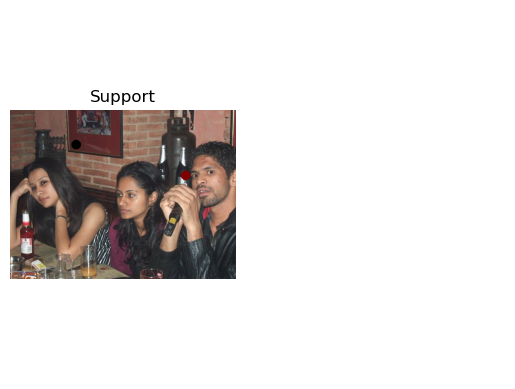

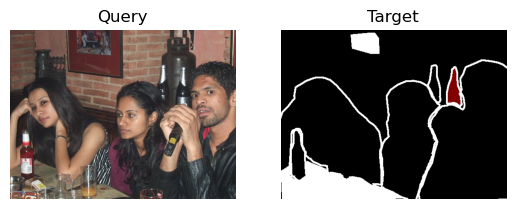

In [14]:
sparse_ds = SparseSeg(mask_ds, count=1)
inter_ds = InteractiveSeg(mask_ds, sparse_ds)
load_and_show(inter_ds, 1)

When the query is a new image, we have a few-shot learning task.
Here the task is to segment the semantic category indicated by the support annotations.

In [18]:
sem_ds = VOCSemSeg(root_dir=DATA_DIR, split='train')
mask_ds = MaskSemSeg(sem_ds)
# support_datasets = [TargetFilter(mask_ds, [c]) for c in range(1, len(sem_ds.classes))]
support_datasets = [TargetFilter(mask_ds, [c]) for c in range(1, 3)]
sparse_datasets = [SparseSeg(ds, count=5) for ds in support_datasets]

()


IndexError: ignored

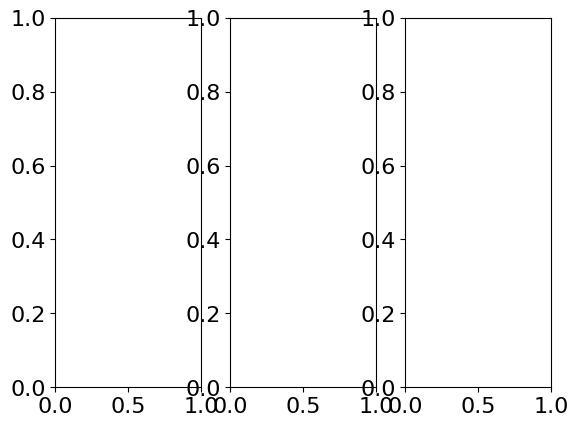

In [ ]:
SHOT = 2
cond_ds = ConditionalSemSeg(mask_ds, sparse_datasets, shot=SHOT)
load_and_show(cond_ds, SHOT)